# Cart-Pole with Walls, Hybrid MPC Demo

This is a demo for the Model Predictive Control (MPC) package $\texttt{mpc_tools}$.

In [1]:
%load_ext autoreload
%autoreload 2
#%pylab notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pympc.dynamical_systems as ds
import pympc.plot as mpc_plt
from pympc.control import MPCHybridController
from pympc.geometry import Polytope

numeric parameters

In [3]:
mc = 1.
mp = 1.
l = 1.
d = 1.
k = 100.
g = 10.
t_s = .05

dynamics

In [4]:
# dynamics n.1
A_1 = np.array([
    [0., 0., 1., 0.],
    [0., 0., 0., 1.],
    [0., (g*mp)/mc, 0., 0.],
    [k/(l*mp), (g*mp**2 + g*mc*mp - k*l*mc)/(l*mc*mp), 0., 0.]
    ])
B_1 = np.array([
    [0.],
    [0.],
    [1./mc],
    [1./(l*mc)]
    ])
c_1 = np.array([
    [0.],
    [0.],
    [0.],
    [(d*k)/(l*mp)]
    ])
S_1 = ds.DTAffineSystem.from_continuous(A_1, B_1, c_1, t_s)

# dynamics n.2
A_2 = np.array([
    [0., 0., 1., 0.],
    [0., 0., 0., 1.],
    [0., (g*mp)/mc, 0., 0.],
    [0., g*(mc+mp)/(l*mc), 0., 0.]
    ])
B_2 = np.array([
    [0.],
    [0.],
    [1./mc],
    [1./(l*mc)]
    ])
c_2 = np.zeros((4,1))
S_2 = ds.DTAffineSystem.from_continuous(A_2, B_2, c_2, t_s)

# dynamics n.3
A_3 = np.array([
    [0., 0., 1., 0.],
    [0., 0., 0., 1.],
    [0., (g*mp)/mc, 0., 0.],
    [k/(l*mp), (g*mp**2 + g*mc*mp - k*l*mc)/(l*mc*mp), 0., 0.]
    ])
B_3 = np.array([
    [0.],
    [0.],
    [1./mc],
    [1./(l*mc)]
    ])
c_3 = np.array([
    [0.],
    [0.],
    [0.],
    [-(d*k)/(l*mp)]
    ])
S_3 = ds.DTAffineSystem.from_continuous(A_3, B_3, c_3, t_s)

# list of dynamics
S = [S_1, S_2, S_3]

The domains of the PWA have to be expressed as polytopes.

In [5]:
# state bounds
x_max = np.array([[2.*d],[np.pi/8.],[5.],[2.*np.pi]])
x_min = -x_max

# state domain n.1
lhs_1 = np.array([[1., -l, 0., 0.]])
rhs_1 = np.array([[-d]])
X_1 = Polytope.from_bounds(x_min, x_max)
X_1.add_facets(lhs_1, rhs_1)
X_1.assemble()

# state domain n.2
lhs_2 = np.array([[-1., l, 0., 0.], [1., -l, 0., 0.]])
rhs_2 = np.array([[d], [d]])
X_2 = Polytope.from_bounds(x_min, x_max)
X_2.add_facets(lhs_2, rhs_2)
X_2.assemble()

# state domain n.3
lhs_3 = np.array([[-1., l, 0., 0.]])
rhs_3 = np.array([[-d]])
X_3 = Polytope.from_bounds(x_min, x_max)
X_3.add_facets(lhs_3, rhs_3)
X_3.assemble()

# list of state domains
X = [X_1, X_2, X_3]

# input domain
u_max = np.array([[100.]])
u_min = -u_max
U = Polytope.from_bounds(u_min, u_max)
U.assemble()
U = [U]*3

We can now define the PWA system.

In [6]:
pwa_sys = ds.DTPWASystem(S, X, U)

In [7]:
# controller parameters
N = 10
Q = np.eye(A_1.shape[0])
R = np.eye(B_1.shape[1])
objective_norm = 'two'

# terminal set and cost
P, K = ds.dare(S[1].A, S[1].B, Q, R)
X_N = ds.moas_closed_loop(S[1].A, S[1].B, K, X[1], U[1])

print X_N.lhs_min.shape[0]

# hybrid controller
controller = MPCHybridController(pwa_sys, N, objective_norm, Q, R, P, X_N)

116


We can now simulate the closed-loop dynamics starting from the initial state $x_0$.

In [8]:
N_sim = 100
x_0 = np.array([[0.],[0.],[2.2],[0.]])
u = []
x = []
x.append(x_0)
for k in range(N_sim):
    u.append(controller.feedback(x[k]))
    x_next = pwa_sys.simulate(x[k], [u[k]])[0][1]
    x.append(x_next)

We can use the plot functions to visualize the time evolution of the system.

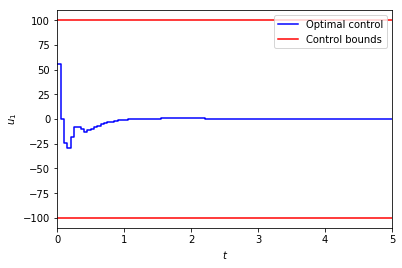

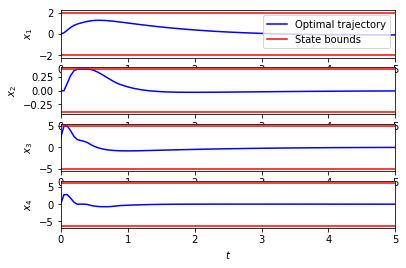

In [9]:
mpc_plt.input_sequence(u, t_s, (u_min, u_max))
plt.show()
mpc_plt.state_trajectory(x, t_s, (x_min, x_max))
plt.show()

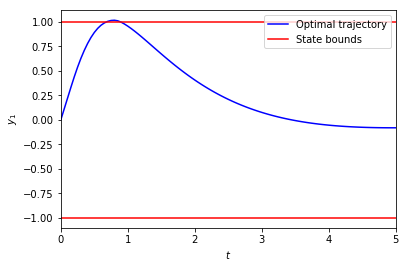

In [10]:
C = np.array([[1., -l, 0., 0.]])
y_max = np.array([[d]])
y_min = -y_max
mpc_plt.output_trajectory(C, x, t_s, (y_min, y_max))
plt.show()